# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boing 747 or an Airbus A380

There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
tmp_name='tmp_old'
PATH = "../../datasets/boeing_vs_airbus/"
!rm -r {PATH}{tmp_name} # do that to avoid

In [3]:
## Getting dataset
#!mkdir ../../datasets/boing_vs_airbus
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
#!ls {PATH}

In [4]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
print("Loading Fast.AI modules...")

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

sz=299
#arch=resnet34 # F2 :  0.937
arch=resnext50
#arch=resnext101_64
bs=132

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


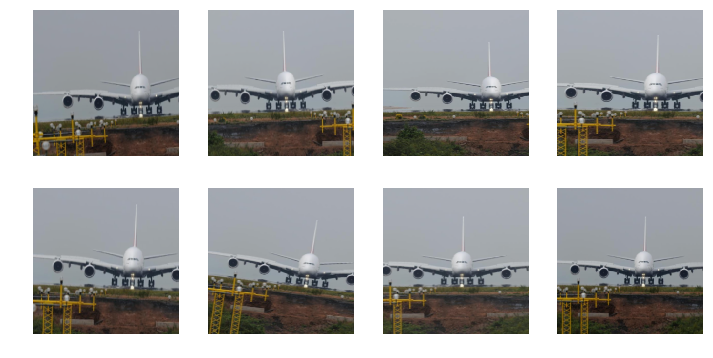

In [5]:

aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1,crop_type=CropType.RANDOM)
# Taille de batch faible pour trouver le bon learning rate
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())

def get_augs():
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2, num_workers=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(8)])
plots(ims, rows=2)

In [6]:
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, tmp_name=tmp_name)
learn.unfreeze()
# resnet34 : acc 93.54%, F2 :  0.93, for learning_rate = 1e-3, dropout = [0.25,0.5], 
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]

# Resnext50 : 95.48%, F2 :  0.96, learning_rate = 1e-3, dropout = [0.25,0.5], 
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]

# resnext101_64: 93.87 % F2 :  0.95, learning_rate = 1e-3, dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]

# resnext101_64: F2 :  0.94 (94.51 %)
# After  175  epochs, the accuracy is  94.51 %
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3]
#     [64, 600, 3],
#     [123, 300, 6]
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 6]
#=> With same parameters resnext50 is better than resnet34 and resnext101_64
    
# resnext101_64:  F2 :  0.94 (acc 94.19 %, sometimes 97%) , learning_rate = 1e-3, dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 6],
#     [123, 300, 6],
#     [123, 400, 6]
# ]
# After  204  epochs, the accuracy is  94.19 %


# Resnext50 F2 :  0.97 (acc 97.09 %) learning_rate = 1e-3, dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 6],
#     [123, 300, 6],
#     [123, 400, 6]
# ]
# After  78  epochs, the accuracy is  96.12 %
# After  141  epochs, the accuracy is  98.06 %
# After  204  epochs, the accuracy is  97.09 %

# F2 :  0.97 (acc 94.51 %) for learning_rate = 1e-3, dropout = [0.25,0.5]
#     [512, 64, 4],
#     [256, 128, 6],
#     [123, 300, 6]
#After  15  epochs, the accuracy is  91.93 %
#After  78  epochs, the accuracy is  94.83 %
#After  141  epochs, the accuracy is  94.51 %

# XXX test with crop_type=CropType.NO
# for learning_rate = 1e-3, dropout = [0.25,0.5]
#     [512, 64, 4],
#     [256, 128, 6],
#     [123, 300, 6]
#After  141  epochs, the accuracy is  95.80 %

# F2 :  0.97 test with crop_type=CropType.NO
#     [512, 64, 4],
#     [256, 128, 6],
#     [123, 300, 7]
#After  205  epochs, the accuracy is  96.77 %

learning_rate = 1e-3
dropout = [0.25,0.5]
global_results = collections.OrderedDict([])
lr = np.array([learning_rate/10,learning_rate/5,learning_rate])
training_loop = [
    [512, 64, 5, lr, CropType.RANDOM, dropout],
    [256, 128, 5, lr, CropType.RANDOM, dropout],
    [123, 300, 5, lr, CropType.RANDOM, dropout],
    [123, 300, 5, lr, CropType.NO, [0.25, 0.5, 0.7]],
    [123, 300, 5, lr, CropType.RANDOM, 0.6],
    [123, 300, 5, lr, CropType.RANDOM, dropout],
    [123, 300, 5, lr, CropType.RANDOM, dropout],
    [123, 300, 5, lr, CropType.NO, 0.3],
    [123, 300, 5, lr, CropType.NO, 0.7],
    [123, 400, 5, lr, CropType.RANDOM, 0.5],
    [123, 400, 5, lr, CropType.NO, 0.7],
    [123, 300, 5, lr, CropType.RANDOM, dropout],
    [123, 300, 5, lr, CropType.RANDOM, 0.7],
    [123, 300, 5, lr, CropType.NO, dropout],
    [123, 300, 5, lr/10, CropType.RANDOM, 0.7],
    [123, 300, 5, lr, CropType.NO, dropout]
    #[123, 400, 6]
]
i = 0
for bs, sz, cycle, lr, crop_type, ps in training_loop:
    i+=1
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5, crop_type=crop_type)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    learn.ps = ps
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True,
                                      best_save_name=arch.__name__ + "-" + str(i) +  "_clean_bestmodel")
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items():
            global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
   
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    print(" with hyperparameters : Batch size=", bs, " Drop out=", ps, " Learning rate=", lr, " Cycle=", cycle, " Images sizes=", sz )
    fichier = "acc" + str(vals_s2s[1]*100)[:5] + '_' + arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)

epoch      trn_loss   val_loss   accuracy                    
    0      0.655676   0.54909    0.741935  
    1      0.509259   0.480901   0.748387                    
    2      0.39569    0.393159   0.793548                    
    3      0.396491   0.310566   0.864516                    
    4      0.327878   0.292748   0.86129                     
    5      0.249147   0.300181   0.867742                    
    6      0.245994   0.271587   0.887097                    
    7      0.195002   0.308631   0.83871                     
    8      0.220833   0.250041   0.890323                    
    9      0.189935   0.215693   0.912903                    
    10     0.160079   0.200025   0.916129                    
    11     0.162693   0.201708   0.909677                    
    12     0.172055   0.208041   0.919355                    
    13     0.125155   0.211143   0.909677                    
    14     0.138731   0.203635   0.912903                    
    15     0.170511   0.20

epoch      trn_loss   val_loss   accuracy                     
    0      0.078261   0.209889   0.903226  
    1      0.113643   0.180237   0.93871                      
    2      0.130082   0.182119   0.919355                    
    3      0.065474   0.207056   0.916129                     
    4      0.068968   0.188422   0.922581                     
    5      0.116995   0.156532   0.925806                     
    6      0.094164   0.162545   0.925806                     
    7      0.076832   0.208306   0.912903                     
    8      0.10386    0.156205   0.925806                     
    9      0.102604   0.166619   0.932258                     
    10     0.072181   0.148276   0.945161                     
    11     0.083014   0.150916   0.935484                     
    12     0.100328   0.154839   0.93871                      
    13     0.114858   0.142747   0.945161                     
    14     0.10193    0.140201   0.945161                     
    15     0

epoch      trn_loss   val_loss   accuracy                     
    0      0.049568   0.135098   0.941935  
    1      0.041917   0.16365    0.941935                     
    2      0.073417   0.149467   0.948387                     
    3      0.115214   0.151311   0.922581                     
    4      0.080577   0.136516   0.948387                     
    5      0.083876   0.13614    0.93871                      
    6      0.099143   0.136842   0.941935                     
    7      0.039068   0.153976   0.93871                      
    8      0.07615    0.145476   0.932258                     
    9      0.07014    0.145889   0.93871                      
    10     0.072049   0.145082   0.951613                     
    11     0.045884   0.152456   0.932258                     
    12     0.099278   0.164185   0.941935                     
    13     0.045117   0.142041   0.93871                      
    14     0.082002   0.145142   0.945161                     
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.070044   0.125018   0.948387  
    1      0.107681   0.121668   0.948387                     
    2      0.066971   0.129728   0.945161                     
    3      0.088823   0.150255   0.922581                     
    4      0.097822   0.139846   0.929032                     
    5      0.047647   0.126135   0.948387                     
    6      0.111319   0.124264   0.948387                     
    7      0.0604     0.161417   0.93871                      
    8      0.054606   0.149373   0.932258                     
    9      0.061486   0.222821   0.906452                     
    10     0.083274   0.171166   0.922581                     
    11     0.106808   0.181145   0.929032                     
    12     0.079212   0.168672   0.925806                     
    13     0.073784   0.156693   0.93871                      
    14     0.04223    0.158065   0.932258                     
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.066336   0.141328   0.929032  
    1      0.045193   0.154101   0.93871                      
    2      0.061042   0.159978   0.929032                     
    3      0.057669   0.201654   0.929032                     
    4      0.081435   0.180463   0.922581                     
    5      0.051617   0.146709   0.93871                      
    6      0.068434   0.156335   0.93871                      
    7      0.07851    0.149293   0.932258                     
    8      0.083857   0.147509   0.922581                     
    9      0.068933   0.11411    0.93871                      
    10     0.066912   0.117568   0.948387                     
    11     0.078083   0.119384   0.945161                     
    12     0.107488   0.13419    0.929032                     
    13     0.050778   0.122501   0.93871                      
    14     0.046305   0.114589   0.948387                     
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.052817   0.150302   0.929032  
    1      0.028922   0.140235   0.93871                      
    2      0.031277   0.111003   0.96129                      
    3      0.032855   0.210187   0.912903                     
    4      0.069819   0.138696   0.945161                     
    5      0.033071   0.152233   0.935484                     
    6      0.042801   0.125273   0.945161                     
    7      0.116187   0.233778   0.906452                     
    8      0.102609   0.195512   0.919355                     
    9      0.060621   0.13896    0.935484                     
    10     0.061363   0.127536   0.948387                     
    11     0.032265   0.162976   0.929032                     
    12     0.050795   0.145677   0.941935                     
    13     0.072425   0.158398   0.935484                     
    14     0.040007   0.128635   0.935484                     
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.05189    0.170241   0.932258  
    1      0.039149   0.126097   0.96129                      
    2      0.034643   0.154769   0.93871                      
    3      0.085537   0.14781    0.951613                     
    4      0.077783   0.188656   0.916129                     
    5      0.031582   0.14525    0.951613                     
    6      0.044892   0.169836   0.929032                     
    7      0.074018   0.153094   0.932258                     
    8      0.052427   0.154709   0.932258                     
    9      0.042193   0.11837    0.954839                     
    10     0.040216   0.155751   0.935484                     
    11     0.074618   0.128766   0.948387                     
    12     0.05015    0.148935   0.941935                     
    13     0.074939   0.151203   0.941935                     
    14     0.041699   0.176103   0.935484                     
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.023491   0.137519   0.945161  
    1      0.020282   0.131323   0.948387                     
  3%|▎         | 4/151 [00:09<06:01,  2.46s/it, loss=0.0189]

KeyboardInterrupt: 

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot_loss()

In [ ]:
print("Iterations : ", len(learn.sched.losses))
#ep_vals_s2s.values()
print("Epochs : ", len(global_results))

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = len(ep_vals)#ep_vals.keys()
    #plt.xticks(np.asarray(list(epochs)))
    plt.xticks((list(ep_vals)))
    #print((list(ep_vals)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    #print(trn_losses)
    val_losses = [item[1] for item in list(ep_vals.values())]
    #print(val_losses)
    plt.plot(list(ep_vals), trn_losses, c='b', label='train')
    plt.plot(list(ep_vals), val_losses, c='r', label='validation')
    plt.legend(loc='upper left')
plot_ep_vals(global_results)

# Prediction et visualisation

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

## Precision and Recall
Précision et rappel en français : https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel
_La précision est le nombre de documents pertinents retrouvés rapporté au nombre de documents total proposé par le moteur de recherche pour une requête donnée. _ Autrement dit quelle proportion d'identifications positives était effectivement correcte ?

_Le rappel est défini par le nombre de documents pertinents retrouvés au regard du nombre de documents pertinents que possède la base de données._ Autrement dit quelle proportion de résultats positifs réels a été identifiée correctement ?

In [ ]:
# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

In [ ]:
# This is the label for a val data
plt.hist(data.val_y)

In [ ]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

In [ ]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape  # = (num of prediction , num of classes)

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [ ]:
# Récupère aléatoirement des prédictions
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 8), replace=False)

# Récupère les prédictions correctes
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# Affiche les images
def plots(ims, figsize=(20,10), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

# Charge l'image
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Affiche des images avec un titre
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(str(probs[x]) + "\n" + str(data.val_ds.fnames[x][10:][:20])) for x in idxs]
    print(title)
    return plots(imgs, rows=2, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

# Recupère les prédiction triées
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:8]] # Les 32 premiers éléments

# Recupère les prédictions les plus justes
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect " + data.classes[0])

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect " + data.classes[1])

In [ ]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:8]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct " + data.classes[1])

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct " + data.classes[0])